In [ ]:
import librosa
import json
import numpy as np


with open("mapping.json", "r", encoding="utf-8") as file:
    mapping_raw = json.load(file)

x_train = []

for file in mapping_raw:
    path = f"cropped/audio-{file['index']}.mp3"

    audio, sr = librosa.load(path, sr=None)
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    mfcc = librosa.feature.mfcc(y=audio_resampled, sr=16000, n_mfcc=13)
    x_train.append(mfcc)

x_train = np.array(x_train)
x_train = x_train / np.max(np.abs(x_train))
np.save("x_train", x_train)

In [8]:
import numpy as np

x_train = np.load("x_train.npy")
print(x_train.shape)

(71, 13, 938)


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras import Model

import tensorflow as tf


class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, dim_embeddings, beta=0.25, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.num_embeddings = num_embeddings
        self.dim_embeddings = dim_embeddings
        self.beta = beta

        self.embeddings = self.add_weight(
            shape=(num_embeddings, dim_embeddings),
            initializer="uniform",
            trainable=True,
        )

    def call(self, inputs):
        flat_inputs = tf.reshape(inputs, [-1, self.dim_embeddings])

        distances = (
            tf.reduce_sum(flat_inputs**2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings**2, axis=1)
            - 2 * tf.matmul(flat_inputs, self.embeddings, transpose_b=True)
        )

        indices = tf.argmax(-distances, axis=1)
        encodings = tf.one_hot(indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings)
        quantized = tf.reshape(quantized, tf.shape(inputs))

        e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - inputs) ** 2)
        q_latent_loss = tf.reduce_mean((quantized - tf.stop_gradient(inputs)) ** 2)
        loss = q_latent_loss + self.beta * e_latent_loss
        self.add_loss(loss)

        quantized = inputs + tf.stop_gradient(quantized - inputs)
        return quantized, indices


class VQVAE(Model):
    def __init__(self, latent_dim, input_shape, num_embeddings, **kwargs):
        super(VQVAE, self).__init__(**kwargs)

        self.latent_dim = latent_dim
        self.input_shape = input_shape
        self.num_embeddings = num_embeddings

        self.encoder = Encoder(input_shape=input_shape, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        self.vector_quantizer = VectorQuantizer(num_embeddings, latent_dim)

    def call(self, inputs):
        z = self.encoder(inputs)

        quantized, _ = self.vector_quantizer(z)

        reconstructions = self.decoder(quantized)
        return reconstructions

    def compute_loss(self, x, y):
        x_recon = self.call(x)
        reconstruction_loss = tf.reduce_mean(tf.square(y - x_recon))
        return reconstruction_loss

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x, y)
            total_loss = loss + tf.reduce_sum(self.vector_quantizer.losses)

        trainable = self.trainable_variables + self.vector_quantizer.trainable_variables
        gradients = tape.gradient(total_loss, trainable)
        self.optimizer.apply_gradients(zip(gradients, trainable))

        return {"loss": loss}

    def get_config(self):
        config = super(VQVAE, self).get_config()

        config.update(
            {
                "latent_dim": self.latent_dim,
                "input_shape": self.input_shape,
                "num_embeddings": self.num_embeddings,
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        latent_dim = config.pop("latent_dim")
        input_shape = config.pop("input_shape")
        num_embeddings = config.pop("num_embeddings")
        return cls(latent_dim, input_shape, num_embeddings, **config)


def Encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(128, 2, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(2, padding="same")(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(2, padding="same")(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2, padding="same")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(latent_dim)(x)
    return Model(inputs, outputs, name="Encoder")


def Decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(13 * 16)(inputs)
    x = layers.Reshape((13, 16))(x)
    x = layers.Conv1DTranspose(32, 2, padding="same", activation="relu")(x)
    x = layers.Conv1DTranspose(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv1DTranspose(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv1DTranspose(1, 3, padding="same", activation="tanh")(x)
    return Model(inputs, x, name="Decoder")

In [ ]:
model = VQVAE(2, x_train.shape[1:], 256)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

model.fit(x_train, x_train, epochs=500)
model.save("model.keras")

In [4]:
model = keras.models.load_model("model.keras", custom_objects={"VQVAE": VQVAE})

c:\Users\Smile\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [29]:
import numpy as np

z = np.array(model.encoder(x_train))
np.save("z", z)

In [6]:
import numpy as np

z = np.load("z.npy")

In [9]:
z = model.encoder(x_train)

print(np.mean(z, axis=0))
print(np.std(z, axis=0))

[-0.01807128 -0.0142704 ]
[0.05052576 0.05717147]


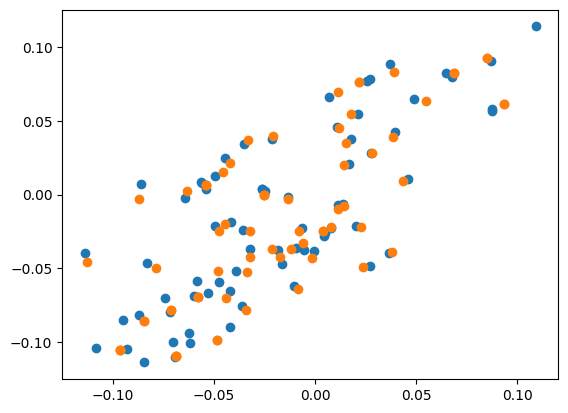

In [10]:
z = model.encoder(x_train)
z2, _ = model.vector_quantizer(z)
# embeddings = np.array(model.vector_quantizer.embeddings)

import matplotlib.pyplot as plt

plt.scatter(z[:, 0], z[:, 1])
plt.scatter(z2[:, 0], z2[:, 1])
# plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.show()

In [ ]:
import IPython

target = np.random.randint(0, 71)
dot = np.linalg.norm(z[target] - z, axis=1)
i = np.argmin(np.where(dot == 0, np.inf, dot))

IPython.display.display(IPython.display.Audio(f"cropped/audio-{target+1}.mp3"))
IPython.display.display(IPython.display.Audio(f"cropped/audio-{i+1}.mp3"))

In [ ]:
import IPython

target = np.random.randint(0, 71)
norm = np.linalg.norm(z, axis=1)
dot = np.dot(z, z[target]) / norm
mask = np.all(z[target] == z, axis=1)
dot[mask] = -np.inf
i = np.argmax(dot)

IPython.display.display(IPython.display.Audio(f"cropped/audio-{target+1}.mp3"))
IPython.display.display(IPython.display.Audio(f"cropped/audio-{i+1}.mp3"))

In [ ]:
import IPython

target = np.random.randint(0, 71)
norm = np.linalg.norm(z, axis=1)
dot = np.dot(z, z[target]) / norm
mask = np.all(z[target] == z, axis=1)
dot[mask] = np.inf
i = np.argmin(dot)

IPython.display.display(IPython.display.Audio(f"cropped/audio-{target+1}.mp3"))
IPython.display.display(IPython.display.Audio(f"cropped/audio-{i+1}.mp3"))

In [11]:
from keras import saving


@saving.register_keras_serializable()
class Sigma(Model):
    def __init__(self, **kwargs):
        super(Sigma, self).__init__(**kwargs)
        self.encoder = SigmaEncoder()
        self.decoder = SigmaDecoder()

    def call(self, inputs):
        z = self.encoder(inputs)
        reconstructions = self.decoder(z)
        return reconstructions

    def compute_loss(self, x, y):
        z = self.encoder(x)
        recon = self.decoder(z)

        mean = tf.reduce_mean(z)
        std = tf.math.reduce_std(z)

        target_mean = 0
        target_std = (1 - 0.001) * tf.stop_gradient(std)

        kl_divergence = tf.reduce_mean(
            tf.math.log(target_std / std)
            + (tf.square(std) + tf.square(mean - target_mean))
            / (2 * tf.square(target_std))
            - 0.5
        )

        reconstruction_loss = tf.reduce_mean(tf.square(y - recon))
        return reconstruction_loss + 0.001 * kl_divergence, std

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            loss, sigma = self.compute_loss(x, y)
            total_loss = loss

        trainable = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable)
        self.optimizer.apply_gradients(zip(gradients, trainable))

        return {"loss": loss, "sigma": sigma}

    def get_config(self):
        config = super(Sigma, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def SigmaEncoder():
    inputs = layers.Input(shape=(2, 2))
    x = layers.Flatten()(inputs)
    x = layers.Dense(4, activation="relu")(x)
    output = layers.Dense(1)(x)
    return Model(inputs, output, name="Encoder")


def SigmaDecoder():
    inputs = layers.Input(shape=(1,))
    x = layers.Dense(4, activation="relu")(inputs)
    output = layers.Dense(3)(x)
    return Model(inputs, output, name="Decoder")


sigma = keras.models.load_model("sigma.keras", custom_objects={"sigma": Sigma})
mean, std = 2.8332459e-05, 0.0016707964

c:\Users\Smile\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


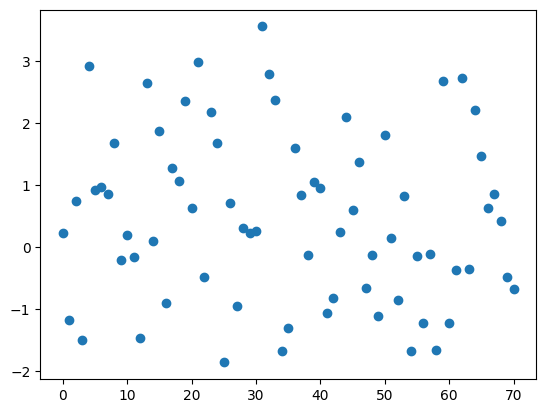

In [38]:
import IPython
import matplotlib.pyplot as plt

target = np.random.randint(0, 71)
x = np.array([[z[target], v] for v in z])
sz = (np.array(sigma.encoder(x)) - mean) / std

plt.scatter(np.arange(0, 71, 1), sz)
plt.show()

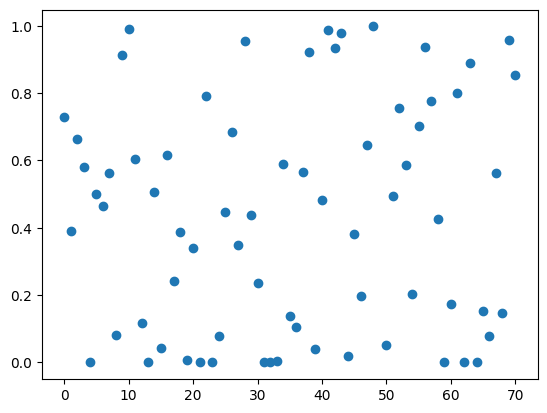

In [32]:
import IPython
import matplotlib.pyplot as plt

target = np.random.randint(0, 71)
x = np.array([[z[target], v] for v in z])
sz = (np.array(sigma.encoder(x)) - mean) / std
sz = np.exp(-np.square(sz))

mask = np.all(z[target] == z, axis=1)
sz[mask] = -np.inf
i = np.argmax(sz)

plt.scatter(np.arange(0, 71, 1), sz)
# plt.plot(np.arange(0, 71, 1), [1.0 for _ in range(0, 71)], "r")
plt.show()

IPython.display.display(IPython.display.Audio(f"cropped/audio-{target+1}.mp3"))
IPython.display.display(IPython.display.Audio(f"cropped/audio-{i+1}.mp3"))

In [24]:
import IPython
from ipywidgets import interactive, widgets

x = np.array([[z[target], v] for v in z])

target = np.random.randint(0, 71)


def callback(a):
    sz = (np.array(sigma.encoder(x)) - mean) / std
    sz = np.exp(-np.square(sz))
    sz = np.abs(sz - a)

    mask = np.all(z[target] == z, axis=1)
    sz[mask] = np.inf
    i = np.argmin(sz)

    print(target, i)
    IPython.display.display(IPython.display.Audio(f"cropped/audio-{target+1}.mp3"))
    IPython.display.display(IPython.display.Audio(f"cropped/audio-{i+1}.mp3"))


interactive(callback, a=widgets.FloatSlider(min=0.0, max=1.0, step=0.01))

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0, step=0.01), Output()), _dom_classes=('w…